# 1. Все точки над IoU и NMS

### IoU (Intersection over Union)
Оценка совпадений двух bbox по отношению пересечения и объединения их площадей:

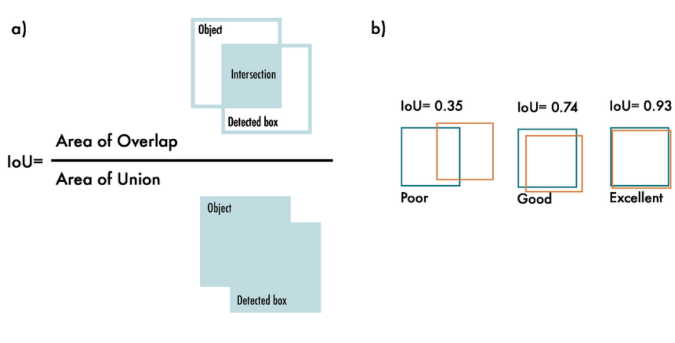


**Задача детекции (обнаружения) - две стадии:**
1. Генерация множества рамок-кандидатов для объектов
2. Классификация объектов во всех рамках-кандидатах
3. Окончатеьная окализация объекта - предсказание ограничивающих рамок (bbox) на основе алгоритма NMS

**Алгоритм подсчета TP, FP, TN, FN для задачи детекции:** раз две стадии детекции - два компонента ошибки:
1. Метрика IoU
2. Корректный класс / не корректный класс

В задачах обычной классификации в отличие от детекции объектом для классификации подразумевается изображение ПОЛНОСТЬЮ. Классификаторы и детекторы имеют архитектурные особенности, разметка классификации и детекции принипиально различна: нельзя просто так взять детектор ("из коробки" - как есть, без модификации архитектуры), и по разметке под классификацию (только метки класов) делать классификацию.

### Может ли сеть предсказывать несколько (много) вероятных рамок для одного истинного объекта?
Краткий ответ - да. Число рамок-кандидатов для каждого объекта регулируется параметром **NMS (non-maximum supression - выделение максимума)**. Большинство алгоритмов детекции используют [NMS](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/), чтобы сократить количество обнаруженных ограничивающих рамок до нескольких (т.к. большинство детекторов проходят окнами различного размера и формы по всему изображению - генерируются тысячи т.н. "якорей" (anchors) различных размеров и форм.

Предположительно, эти окна содержат только один объект, и для получения вероятности принадлежности объекта к конкретному классу уже используется классификатор. Часто для одного объекта в процессе предсказания генерируется несколько сильно перекрывающихся (но не совпадающих окон). Из них выбирается лучшее по критерию **conf<sub>class</sub>** = max, а остальные (т.е. не-максимумы) отбрасываются - если превосходят параметр порог **NMS<sub>IoU</sub>** (NMS treshold, обычно устанавливается **0.5**) - т.е. эти рамки считаются лишними, повторными для одного и того же истинного объекта.

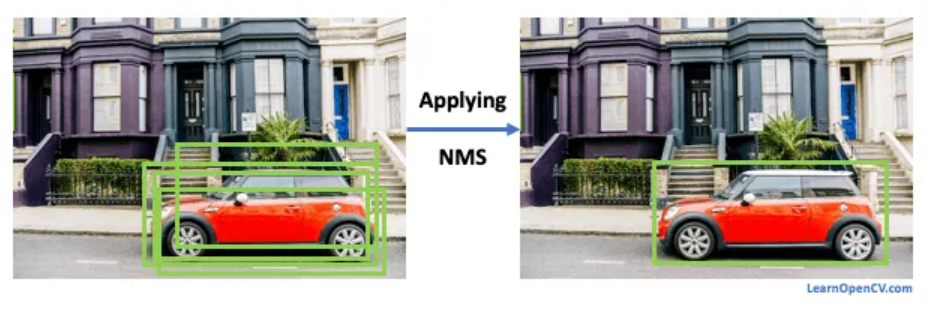

**Работа NMS по стадиями:**
1. Получение множества сильно перекрывающихся рамок-предсказаний для объекта
2. Выбор рамки с высшим **conf<sub>class</sub>**
3. Итерация по оставшимся рамкам: если первосходят **NMS<sub>IoU</sub>** (т.е. перекрываются с лучшей больше чем на половину) --> отбразываются (интерпертируются как рамки-дубли дял того же объекта). Если не провосходят **NMS<sub>IoU</sub>** (перекрываются меньше чем на половину) --> сохраняются (интерпертируются как рамки для другого близкораспложенного объекта того же класса).

**NMS<sub>IoU</sub>** = 0.5 по умолчанию. С ним можно (и нужно!) экспериментировать, напримиер, когда объекты на изображении расположены очень плотно, или наоборот - почти не встречаются рядом.

### Итого: не путать!
- **IoU** - ***компонент*** (один из двух) метрики качества модели-детектора, 0.5 по умолчанию
- **NMS<sub>IoU</sub>** - ***параметр*** настройки модели-детектора, 0.5 по умолчанию

### Как сравнивать y_true и y_pred для детекции?
Краткий ответ - попарно. Т.е. один истинный объект ТОЛЬКО с предсказанием(-ями) именно для него. Допустим:
- для y_true<sub>1</sub> предсказана рамка y_pred<sub>1</sub>,
- для y_true<sub>2</sub> предсказаны несколько рамок [y_pred<sub>2[0]</sub>, y_pred<sub>2[1]</sub>, y_pred<sub>2[2]</sub>]

Сравниваем:
- y_true<sub>1</sub> только с y_pred<sub>1</sub>,
- y_true<sub>2</sub> только с y_pred<sub>2[0]</sub>, y_pred<sub>2[1]</sub> и y_pred<sub>2[2]</sub>

### Что считать TP, FP, FN в задачах детекции?

1. **True Positive (TP):** Предсказание с IoU ≥ conf<sub>IoU</sub> (правильно определило его локализацию), которое при этом правильно определило также класс объекта (метка класса y_pred == y_true).
<p> </p>
1. **False Positive (FP):** 
    - Предсказание, которое имеет IoU < conf<sub>IoU</sub> (ошибка на стадии локализации),
    - IoU ≥ conf<sub>IoU</sub>, но неправильно определен класс объекта, 
    - предсказан объект, которого нет.
<p>&nbsp;</p>

1. **False Negative (FN):** Реальный объект, который модель не смогла обнаружить.